In [83]:
# STEP 1: Import Libraries
# ------------------------
# Import all necessary libraries for data manipulation, visualization, and modeling.

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    precision_recall_curve
)

from xgboost import XGBRegressor, XGBClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.random.set_seed(42)

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

import shap
import seaborn as sns
import folium
from folium.plugins import HeatMap
import geopandas as gpd
import networkx as nx
import lightgbm as lgb

# SMOTE to balance the binary target variable if there are fewer positive samples.
from imblearn.over_sampling import SMOTE

# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# DATASET URL FROM GITHUB
dataset_url= "https://raw.githubusercontent.com/tabrezdn1/olympics-medal-prediction/refs/heads/main/olympics_dataset.csv"


# **EDA on DATASET**

In [84]:
df = pd.read_csv(dataset_url)

# Examine the first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Display information about the dataset, including columns, dtypes, and missing values.
print("\nDataset Info:")
df.info()

First 5 rows of the dataset:
   player_id                   Name Sex            Team  NOC  Year  Season  \
0          0              A Dijiang   M           China  CHN  1992  Summer   
1          1               A Lamusi   M           China  CHN  2012  Summer   
2          2            Gunnar Aaby   M         Denmark  DEN  1920  Summer   
3          3            Edgar Aabye   M  Denmark/Sweden  DEN  1900  Summer   
4         26  Cornelia (-strannood)   F     Netherlands  NED  1932  Summer   

          City       Sport                         Event     Medal  
0    Barcelona  Basketball   Basketball Men's Basketball  No medal  
1       London        Judo  Judo Men's Extra-Lightweight  No medal  
2    Antwerpen    Football       Football Men's Football  No medal  
3        Paris  Tug-Of-War   Tug-Of-War Men's Tug-Of-War      Gold  
4  Los Angeles   Athletics  Athletics Women's 100 metres  No medal  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252565 entries, 0 to 25

In [85]:
missing_values = df.isnull().sum()
print(missing_values)

player_id    0
Name         0
Sex          0
Team         0
NOC          0
Year         0
Season       0
City         0
Sport        0
Event        0
Medal        0
dtype: int64


In [86]:
gender_counts = df['Sex'].value_counts().reset_index()
gender_counts.columns = ['Sex', 'Count']

fig = px.pie(gender_counts, names='Sex', values='Count',
             title='Gender Distribution of Athletes',
             color='Sex',
             color_discrete_map={'M':'blue', 'F':'pink', 'Unknown':'gray'})
fig.show()

In [87]:
top_countries = df['Team'].value_counts().head(10).reset_index()
top_countries.columns = ['Team', 'Athlete_Count']

fig = px.bar(top_countries, x='Athlete_Count', y='Team', orientation='h',
             title='Top 10 Countries by Athlete Count',
             labels={'Athlete_Count':'Number of Athletes', 'Team':'Country'},
             color='Athlete_Count',
             color_continuous_scale='Viridis')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

In [88]:
top10_countries = df['Team'].value_counts().nlargest(10).index
top10_df = df[df['Team'].isin(top10_countries)]
athletes_per_yr_cntry = top10_df.groupby(['Year', 'Team'])['player_id'].count().reset_index()
athletes_per_yr_cntry.columns = ['Year', 'Team','Athlete_Count']

fig = px.line(athletes_per_yr_cntry, x='Year', y='Athlete_Count', color='Team',
              labels={'Athlete_Count':'Number of Athletes'},title='Total Athletes per Year (Top 10 Countries)',
              color_discrete_sequence=["red","blue","yellow","green","pink","orange","purple","magenta","violet","cyan"])
fig.show()

In [89]:
# Group data by Year and ISO_Code to get Athlete_Count
athletes_per_country_year = df.groupby(['Year', 'NOC']).size().reset_index(name='Athlete_Count')

# Display the aggregated data
athletes_per_country_year.head()

,Year,NOC,Athlete_Count
0,1896,AUS,5
1,1896,AUT,8
2,1896,DEN,15
3,1896,FRA,26
4,1896,GBR,25


In [90]:
# Create the animated choropleth map
fig = px.choropleth(
    athletes_per_country_year,
    locations='NOC',
    color='Athlete_Count',
    hover_name='NOC',
    animation_frame='Year',
    color_continuous_scale='Blues',
    range_color=(athletes_per_country_year['Athlete_Count'].min(), athletes_per_country_year['Athlete_Count'].max()),
    title='Athletes Distribution by Country Over Time',
    labels={'Athlete_Count':'Number of Athletes'},
    projection='natural earth'
)

# Update geographical layout for better visualization
fig.update_geos(
    showcountries=True,
    showcoastlines=True,
    showland=True,
    fitbounds="locations",
    landcolor="lightgray",
    oceancolor="lightblue"
)

# Update layout for better aesthetics
fig.update_layout(
    coloraxis_colorbar=dict(
        title="Number of Athletes",
        thickness=15,
        len=0.75,
        yanchor="top",
        y=0.95,
        ticks="outside"
    )
)

fig.show()

In [91]:
sunburst_data = df.groupby(['Sport', 'Event']).size().reset_index(name='Athlete_Count')

fig = px.sunburst(
    sunburst_data,
    path=['Sport', 'Event'],
    values='Athlete_Count',
    color='Athlete_Count',
    color_continuous_scale='RdBu',
    title='Hierarchy of Sports and Events by Athlete Count'
)

fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
fig.show()

In [92]:
df = df.dropna(subset=['Year', 'Sport', 'Sex', 'Team', 'NOC'])
df['Year'] = df['Year'].astype(int)

country_counts = df['Team'].value_counts().reset_index()
country_counts.columns = ['Team', 'Athlete_Count']

top_n = 10
top_countries = country_counts.head(top_n)

top_countries_noc = df[df['Team'].isin(top_countries['Team'])][['Team', 'NOC']].drop_duplicates()

top_countries = top_countries.merge(top_countries_noc, on='Team', how='left')

print("Unique NOC Codes in Top Countries:", top_countries['NOC'].unique())

surface_data = df.groupby(['Sport', 'Year']).size().reset_index(name='Athlete_Count')

surface_pivot = surface_data.pivot(index='Sport', columns='Year', values='Athlete_Count').fillna(0)

surface_pivot = surface_pivot.sort_values(by=surface_pivot.columns.tolist(), ascending=False)

# Initialize figure with subplots
fig = make_subplots(
    rows=2, cols=2,
    column_widths=[0.6, 0.4],
    row_heights=[0.4, 0.6],
    specs=[
        [{"type": "scattergeo", "rowspan": 2}, {"type": "bar"}],
        [None, {"type": "surface"}]
    ],
    subplot_titles=(
        "Geographical Distribution of Athletes",
        "Top 10 Countries by Athlete Count",
        "Athlete Participation Across Sports and Years"
    )
)

# Add Scattergeo map of athlete locations using NOC codes
fig.add_trace(
    go.Scattergeo(
        locations=top_countries['NOC'],
        locationmode='ISO-3',  # Ensures that NOC codes are interpreted as ISO Alpha-3 codes
        text=top_countries['Team'] + ': ' + top_countries['Athlete_Count'].astype(str) + ' Athletes',
        mode="markers",
        marker=dict(
            color="crimson",
            size=10,
            opacity=0.8
        ),
        hoverinfo="text"
    ),
    row=1, col=1
)

# Add bar chart of top 10 countries
fig.add_trace(
    go.Bar(
        x=top_countries['Athlete_Count'][::-1],  # Reverse for descending order
        y=top_countries['Team'][::-1],
        orientation='h',
        marker=dict(color="crimson"),
        hoverinfo='x',
        showlegend=False
    ),
    row=1, col=2
)

# Add 3D surface of athlete participation
fig.add_trace(
    go.Surface(
        z=surface_pivot.values,
        x=surface_pivot.columns.astype(int).tolist(),
        y=surface_pivot.index.tolist(),
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title='Number of Athletes'),
        opacity=0.8
    ),
    row=2, col=2
)

# Update geo subplot properties
fig.update_geos(
    projection_type="natural earth",
    showcountries=True,
    showcoastlines=True,
    showland=True,
    landcolor="lightgray",
    oceancolor="LightBlue",
    countrycolor="white",
    showocean=True
)

fig.update_xaxes(tickangle=45, row=1, col=2)

fig.update_layout(
    template="plotly_dark",
    margin=dict(r=10, t=100, b=40, l=60),
    height=800,
    title_text="Olympic Athletes Dashboard: Geographical Distribution, Top Countries, and Participation Trends",
    annotations=[
        dict(
            text="Source: Olympics Dataset",
            showarrow=False,
            xref="paper",
            yref="paper",
            x=0,
            y=0
        )
    ]
)

fig.show()

Unique NOC Codes in Top Countries: ['USA' 'GBR' 'FRA' 'ITA' 'GER' 'AUS' 'CAN' 'JPN' 'HUN' 'SWE']


In [93]:
# -----------------------------------
# 1. Load and Prepare the Dataset
# -----------------------------------

# Data Cleaning: Drop rows with missing critical information
df = df.dropna(subset=['Year', 'Sport', 'Sex', 'Team', 'NOC'])
df['Year'] = df['Year'].astype(int)

# Aggregate data: Count of athletes per Team (Country)
country_counts = df['Team'].value_counts().reset_index()
country_counts.columns = ['Team', 'Athlete_Count']

# Select top 10 countries for clarity in visualizations
top_n = 10
top_countries = country_counts.head(top_n)

# Extract unique NOC codes for the top countries
top_countries_noc = df[df['Team'].isin(top_countries['Team'])][['Team', 'NOC']].drop_duplicates()

# Merge NOC codes with top_countries
top_countries = top_countries.merge(top_countries_noc, on='Team', how='left')

# Verify unique NOC codes in top_countries
print("Unique NOC Codes in Top Countries:", top_countries['NOC'].unique())

# Aggregate data: Number of athletes per Sport and Year
surface_data = df.groupby(['Sport', 'Year']).size().reset_index(name='Athlete_Count')

# Create a pivot table with Sports as rows and Years as columns
surface_pivot = surface_data.pivot(index='Sport', columns='Year', values='Athlete_Count').fillna(0)

# Sort sports by total athlete count for better visualization
surface_pivot = surface_pivot.sort_values(by=surface_pivot.columns.tolist(), ascending=False)

# -----------------------------------
# 2. Initialize Subplots
# -----------------------------------

# Initialize figure with subplots
fig = make_subplots(
    rows=2, cols=2,
    column_widths=[0.6, 0.4],
    row_heights=[0.4, 0.6],
    specs=[
        [{"type": "scattergeo", "rowspan": 2}, {"type": "bar"}],
        [None, {"type": "surface"}]
    ],
    subplot_titles=(
        "Geographical Distribution of Athletes",
        "Top 10 Countries by Athlete Count",
        "Athlete Participation Across Sports and Years"
    ),
    horizontal_spacing=0.05,  # Reduced spacing between columns
    vertical_spacing=0.05     # Reduced spacing between rows
)

# -----------------------------------
# 3. Add Scattergeo Plot (Simulated 3D Globe)
# -----------------------------------

# Add Scattergeo map of athlete locations using NOC codes
scattergeo_trace = go.Scattergeo(
    locations=top_countries['NOC'],
    locationmode='ISO-3',  # Ensures that NOC codes are interpreted as ISO Alpha-3 codes
    text=top_countries['Team'] + ': ' + top_countries['Athlete_Count'].astype(str) + ' Athletes',
    mode="markers",
    marker=dict(
        color="crimson",
        size=top_countries['Athlete_Count'] / top_countries['Athlete_Count'].max() * 30,  # Scale marker sizes
        opacity=0.8
    ),
    hoverinfo="text"
)

fig.add_trace(
    scattergeo_trace,
    row=1, col=1
)

# -----------------------------------
# 4. Define Frames for Automatic Rotation
# -----------------------------------

# Define the number of frames and the step of rotation
num_frames = 72  # 72 frames for 360/5 degrees rotation steps
rotation_step = 5  # degrees per frame

frames = []

for i in range(num_frames):
    rotation = rotation_step * i
    frame = go.Frame(
        data=[
            go.Scattergeo(
                locations=top_countries['NOC'],
                locationmode='ISO-3',
                text=top_countries['Team'] + ': ' + top_countries['Athlete_Count'].astype(str) + ' Athletes',
                mode="markers",
                marker=dict(
                    color="crimson",
                    size=top_countries['Athlete_Count'] / top_countries['Athlete_Count'].max() * 30,
                    opacity=0.8
                ),
                hoverinfo="text"
            )
        ],
        layout=go.Layout(
            geo=dict(
                projection_rotation=dict(lon=rotation, lat=0, roll=0)
            )
        )
    )
    frames.append(frame)

# Add frames to the figure
fig.frames = frames

# -----------------------------------
# 5. Update Geos for Initial Layout
# -----------------------------------

# Update the Scattergeo projection to 'orthographic' for a globe-like appearance
fig.update_geos(
    projection_type="orthographic",
    showcountries=True,
    showcoastlines=True,
    showland=True,
    landcolor="lightgray",
    oceancolor="Darkblue",
    countrycolor="white",
    showocean=True,
    resolution=50,
    projection_rotation=dict(lon=0, lat=0, roll=0)  # Initial rotation
)

# -----------------------------------
# 6. Add Animation Controls
# -----------------------------------

# Add updatemenus for Play and Pause buttons
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            buttons=[
                dict(label="Play",
                     method="animate",
                     args=[
                         None,
                         dict(frame=dict(duration=50, redraw=True),
                              transition=dict(duration=0),
                              fromcurrent=True,
                              mode='immediate')
                     ]),
                dict(label="Pause",
                     method="animate",
                     args=[
                         [None],
                         dict(frame=dict(duration=0, redraw=False),
                              transition=dict(duration=0),
                              mode='immediate')
                     ])
            ],
            direction="left",
            pad={"r": 10, "t": 87},
            showactive=False,
            x=0.1,
            xanchor="right",
            y=0,
            yanchor="top"
        )
    ]
)

# -----------------------------------
# 7. Add Bar Chart
# -----------------------------------

# Add bar chart of top 10 countries
fig.add_trace(
    go.Bar(
        x=top_countries['Athlete_Count'][::-1],  # Reverse for descending order
        y=top_countries['Team'][::-1],
        orientation='h',
        marker=dict(color="crimson"),
        hoverinfo='x',
        showlegend=False
    ),
    row=1, col=2
)

# Rotate x-axis labels for the bar chart for better readability
fig.update_xaxes(tickangle=0, row=1, col=2)
# fig.update_yaxes(title_text="Countries", row=1, col=2)

# -----------------------------------
# 8. Add 3D Surface Plot
# -----------------------------------

# Add 3D surface of athlete participation
fig.add_trace(
    go.Surface(
        z=surface_pivot.values,
        x=surface_pivot.columns.astype(int).tolist(),
        y=surface_pivot.index.tolist(),
        colorscale='Cividis',
        showscale=True,
        colorbar=dict(title='Number of Athletes'),
        opacity=0.8
    ),
    row=2, col=2
)

# -----------------------------------
# 9. Final Layout Adjustments
# -----------------------------------

# Update layout settings
fig.update_layout(
    template="plotly_dark",
    margin=dict(r=20, t=150, b=60, l=80),
    height=900,  # Increased height for better visibility
    width=1200,  # Increased width for better visibility
    title_text="Olympic Athletes Dashboard: Geographical Distribution, Top Countries, and Participation Trends",
    annotations=[
        dict(
            text="Source: Olympics Dataset",
            showarrow=False,
            xref="paper",
            yref="paper",
            x=0,
            y=0
        )
    ],
    hovermode='closest',
    title_font_size=24,
    title_x=0.5  # Center the title
)

# -----------------------------------
# 10. Display the Figure
# -----------------------------------

fig.show()


Unique NOC Codes in Top Countries: ['USA' 'GBR' 'FRA' 'ITA' 'GER' 'AUS' 'CAN' 'JPN' 'HUN' 'SWE']


In [94]:
df_medals = df[df['Medal'].notnull()]

# Aggregate medal counts by Year and NOC
medal_counts = df_medals.groupby(['Year', 'NOC']).size().reset_index(name='Medal_Count')

# Create animated bar chart
fig = px.bar(medal_counts,
             x='NOC',
             y='Medal_Count',
             color='NOC',
             animation_frame='Year',
             range_y=[0, medal_counts['Medal_Count'].max() + 50],
             title='Medal Counts by Country Over Years',
             labels={'NOC':'Country', 'Medal_Count':'Number of Medals'},
             color_discrete_sequence=["red","blue","yellow","green","pink","orange","purple","magenta","violet","cyan"])

fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

In [95]:
# Aggregate medal types
medal_tally = df_medals.groupby(['NOC', 'Medal']).size().reset_index(name='Count')

# Create bubble chart
fig = px.scatter(medal_tally,
                 x='NOC',
                 y='Count',
                 size='Count',
                 color='Medal',
                 hover_name='NOC',
                 title='Medal Tally by Country and Medal Type',
                 labels={'NOC': 'Country', 'Count': 'Number of Medals'},
                 size_max=60,
                color_discrete_sequence=["orange","blue","silver","gold"])



# **Binary Classification**

Lets start by implementing a binary classification to check if the country will win gold or no

The goal was to predict whether a country (identified by its NOC code) wins at least one gold medal in a given Olympic year. This is a binary classification task where:

1 (Yes): The country wins at least one gold medal. 0 (No): The country does not win any gold medals. We used machine learning models (Random Forest and Neural Network) to build the prediction system and interpreted the results using SHAP (SHapley Additive exPlanations) values.


In [96]:
#1) ROC AUC Determine of model , ALl moel , ROC and AUR model create graph and highlight best
#2) EDA Improve
#3) Total participition, medel no medal pair plot
#4) Fit , evaluate , shap value pair
#5) EDA make quesiton and answer

In [97]:
df = pd.read_csv(dataset_url)

# Examine the first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Display information about the dataset, including columns, dtypes, and missing values.
print("\nDataset Info:")
df.info()

First 5 rows of the dataset:
   player_id                   Name Sex            Team  NOC  Year  Season  \
0          0              A Dijiang   M           China  CHN  1992  Summer   
1          1               A Lamusi   M           China  CHN  2012  Summer   
2          2            Gunnar Aaby   M         Denmark  DEN  1920  Summer   
3          3            Edgar Aabye   M  Denmark/Sweden  DEN  1900  Summer   
4         26  Cornelia (-strannood)   F     Netherlands  NED  1932  Summer   

          City       Sport                         Event     Medal  
0    Barcelona  Basketball   Basketball Men's Basketball  No medal  
1       London        Judo  Judo Men's Extra-Lightweight  No medal  
2    Antwerpen    Football       Football Men's Football  No medal  
3        Paris  Tug-Of-War   Tug-Of-War Men's Tug-Of-War      Gold  
4  Los Angeles   Athletics  Athletics Women's 100 metres  No medal  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252565 entries, 0 to 25

In [98]:
# Keep relevant columns
data = df[['Year', 'NOC', 'Medal']]

#check before and after cleaning records, 30 % more then do oversamping or undersampling to populate those values , use some techique
# Handle missing values
data.dropna(subset=['NOC', 'Medal'], inplace=True)

#one hot encoing - Achha bat explain
# Create a binary target: "Wins Gold" or "Does Not Win Gold"
data['gold_winner'] = data['Medal'].apply(lambda x: 1 if x == 'Gold' else 0)

data.head()

<ipython-input-98-fdd86f75315e>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-98-fdd86f75315e>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Year,NOC,Medal,gold_winner
0,1992,CHN,No medal,0
1,2012,CHN,No medal,0
2,1920,DEN,No medal,0
3,1900,DEN,Gold,1
4,1932,NED,No medal,0


In [99]:
# Aggregate data by NOC and Year
noc_gold = data.groupby(['NOC', 'Year'])['gold_winner'].sum().reset_index()
noc_gold['gold_winner'] = noc_gold['gold_winner'].apply(lambda x: 1 if x > 0 else 0)

data.head()

,Year,NOC,Medal,gold_winner
0,1992,CHN,No medal,0
1,2012,CHN,No medal,0
2,1920,DEN,No medal,0
3,1900,DEN,Gold,1
4,1932,NED,No medal,0


In [100]:
# Add participation feature: Count of unique events participated in by each NOC per year
participation = data.groupby(['NOC', 'Year'])['Medal'].count().reset_index(name='total_participations')
noc_gold = noc_gold.merge(participation, on=['NOC', 'Year'], how='left')

# Inspect the processed dataset
print(noc_gold.head())

   NOC  Year  gold_winner  total_participations
0  AFG  1936            0                    16
1  AFG  1948            0                    25
2  AFG  1956            0                    12
3  AFG  1960            0                    16
4  AFG  1964            0                     8


Why this step matters:

The target variable (gold_winner) is necessary for supervised learning. The feature total_participations captures a country's activity level, which could be predictive of success.

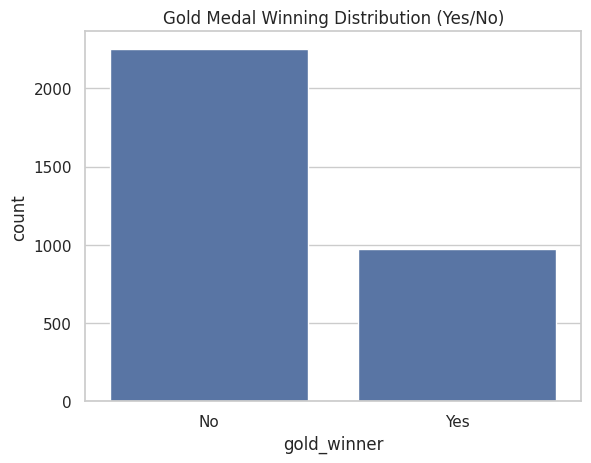

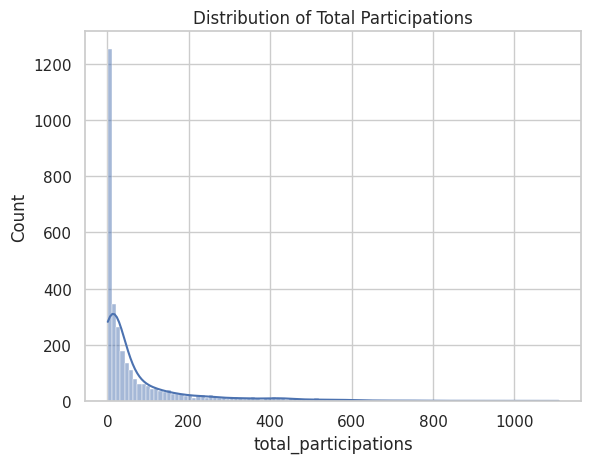

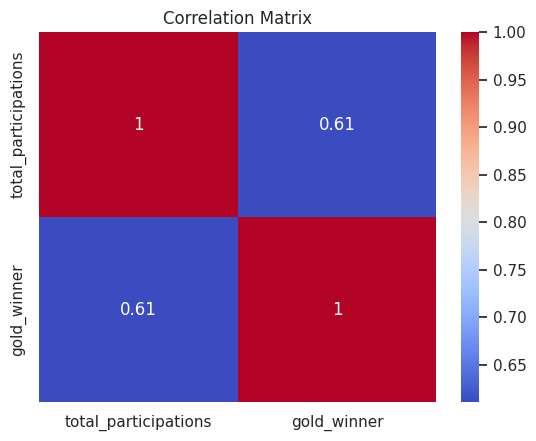

In [101]:
# Target variable distribution
sns.countplot(data=noc_gold, x='gold_winner')
plt.title("Gold Medal Winning Distribution (Yes/No)")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

# Distribution of participation counts
sns.histplot(noc_gold['total_participations'], kde=True)
plt.title("Distribution of Total Participations")
plt.show()

# Correlation matrix
corr_matrix = noc_gold[['total_participations', 'gold_winner']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

What we did:

Analyzed Target Variable Distribution:

Used a count plot to visualize how many countries won at least one gold medal versus those that didn’t. Visualized Feature Distribution:

Plotted a histogram for total_participations to understand its range and distribution. Correlation Analysis:

Created a heatmap to show the correlation between total_participations and gold_winner.

Step 3: Addressing Class Imbalance What we did:

Applied SMOTE (Synthetic Minority Oversampling Technique) to oversample the minority class (gold_winner = 1). Why this step matters:

Imbalanced datasets can lead to biased models that favor the majority class. SMOTE generates synthetic samples for the minority class to balance the dataset. How to interpret results:

After applying SMOTE, the count plot showed an equal number of samples for both classes, ensuring fair model training.

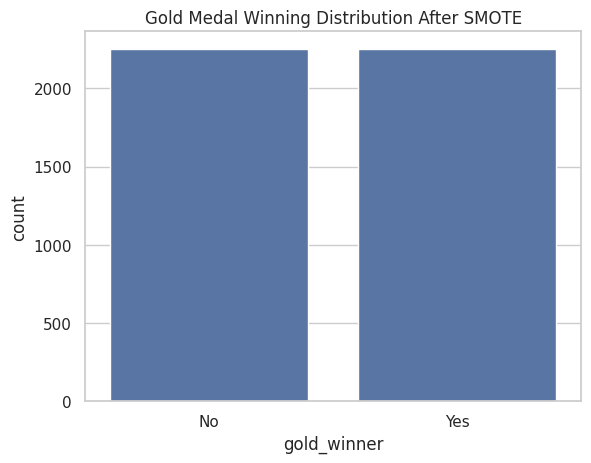

In [102]:
# Features and target
X = noc_gold[['total_participations']]
y = noc_gold['gold_winner']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check distribution after SMOTE
sns.countplot(x=y_resampled)
plt.title("Gold Medal Winning Distribution After SMOTE")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

Step 4: Building Machine Learning Models What we did:

Trained Two Models:

Random Forest: An ensemble tree-based model known for robustness and interpretability. Neural Network: A deep learning model that can capture complex patterns. Evaluated Models:

Metrics: Confusion Matrix: Shows true positives, true negatives, false positives, and false negatives. F1-Score: Balances precision and recall. AUC-ROC: Measures the model’s ability to distinguish between classes. Why this step matters:

Comparing models helps determine which performs better on the given task. How to interpret results:

A high F1-score and AUC-ROC indicate good model performance. The confusion matrix reveals where the model struggles (e.g., false positives).



Training Random Forest...

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       463
           1       0.83      0.85      0.84       438

    accuracy                           0.84       901
   macro avg       0.84      0.84      0.84       901
weighted avg       0.84      0.84      0.84       901



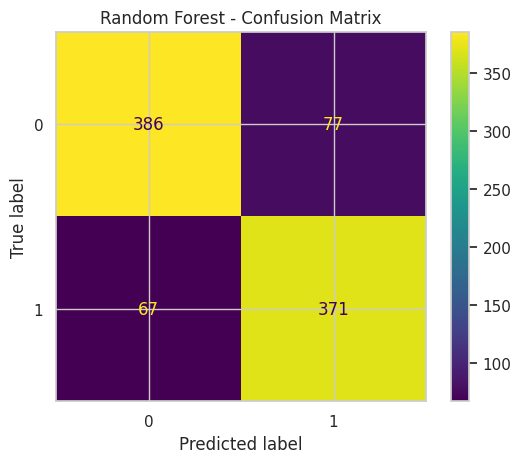

Training Logistic Regression...

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.90      0.86       463
           1       0.89      0.78      0.83       438

    accuracy                           0.84       901
   macro avg       0.85      0.84      0.84       901
weighted avg       0.85      0.84      0.84       901



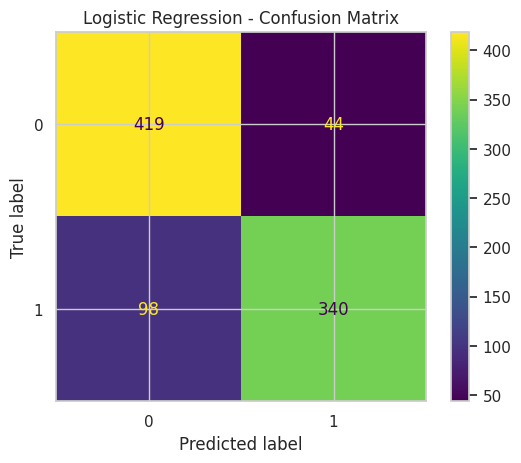

Training SVM...

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       463
           1       0.84      0.85      0.85       438

    accuracy                           0.85       901
   macro avg       0.85      0.85      0.85       901
weighted avg       0.85      0.85      0.85       901



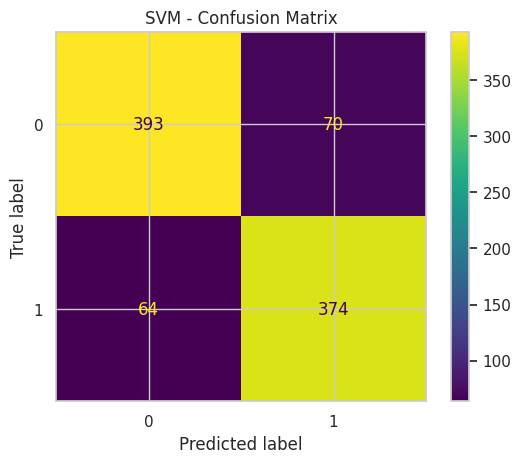

Training KNN...

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       463
           1       0.76      0.84      0.79       438

    accuracy                           0.79       901
   macro avg       0.79      0.79      0.79       901
weighted avg       0.79      0.79      0.79       901



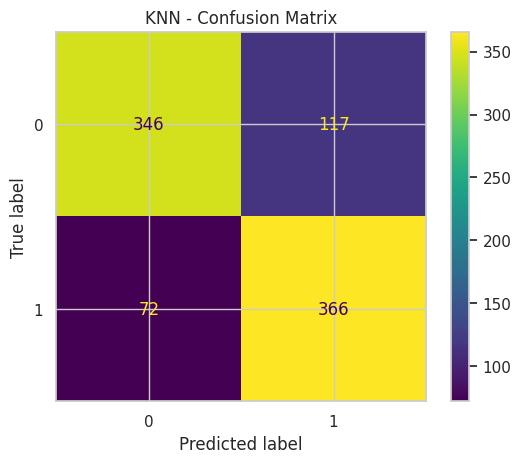

Training Decision Tree...

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       463
           1       0.83      0.83      0.83       438

    accuracy                           0.84       901
   macro avg       0.84      0.84      0.84       901
weighted avg       0.84      0.84      0.84       901



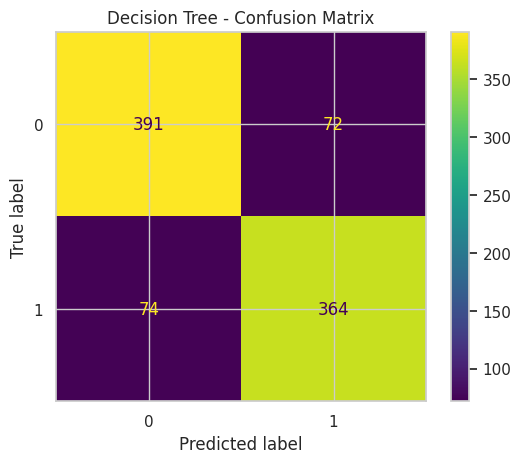

Training AdaBoost...

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       463
           1       0.79      0.89      0.84       438

    accuracy                           0.83       901
   macro avg       0.84      0.84      0.83       901
weighted avg       0.84      0.83      0.83       901



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



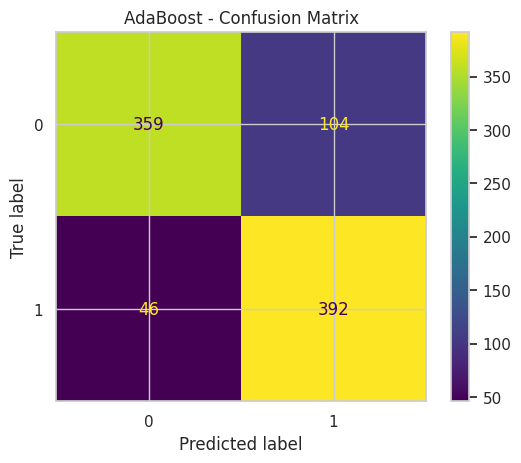

Training XGBoost...

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       463
           1       0.81      0.87      0.84       438

    accuracy                           0.84       901
   macro avg       0.84      0.84      0.84       901
weighted avg       0.84      0.84      0.84       901



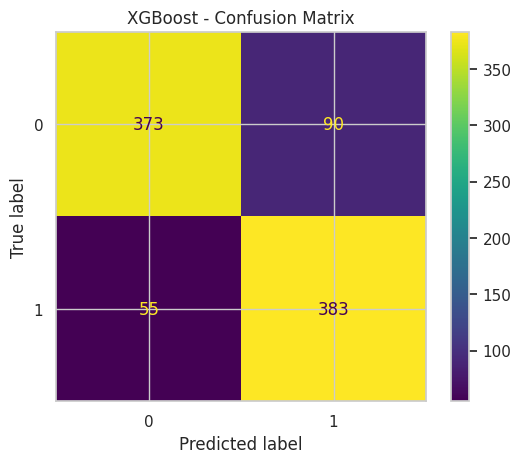

Training LightGBM...
[LightGBM] [Info] Number of positive: 1814, number of negative: 1789
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 3603, number of used features: 1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503469 -> initscore=0.013878
[LightGBM] [Info] Start training from score 0.013878

LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83       463
           1       0.81      0.86      0.83       438

    accuracy                           0.83       901
   macro avg       0.83      0.83      0.83       901
weighted avg       0.83      0.83      0.83       901



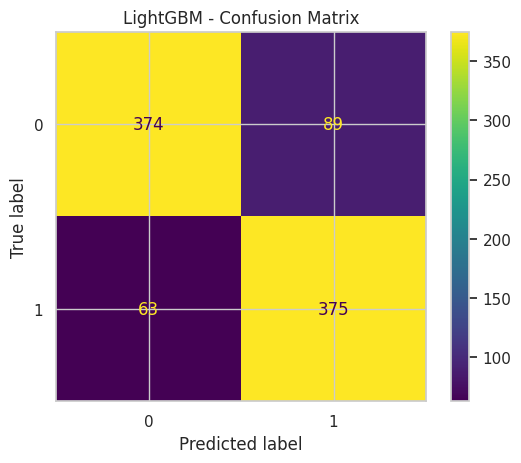


Model Comparison Summary:
                     Accuracy  Precision    Recall  F1-Score   AUC-ROC
Random Forest        0.840178   0.828125  0.847032  0.837472  0.917392
Logistic Regression  0.842397   0.885417  0.776256  0.827251  0.929650
SVM                  0.851276   0.842342  0.853881  0.848073  0.910715
KNN                  0.790233   0.757764  0.835616  0.794788  0.881806
Decision Tree        0.837958   0.834862  0.831050  0.832952  0.908437
AdaBoost             0.833518   0.790323  0.894977  0.839400  0.926028
XGBoost              0.839068   0.809725  0.874429  0.840834  0.930062
LightGBM             0.831299   0.808190  0.856164  0.831486  0.925752


In [103]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scale features for models requiring scaled data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42)
}

# Initialize results dictionary
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")

    # Train and predict
    if name in ["SVM", "KNN", "Logistic Regression"]:  # Scaled data required
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:  # Unscaled data
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    # Store metrics in results dictionary
    results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc
    }

    # Print classification report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Display confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

# Convert results to DataFrame for summary
results_df = pd.DataFrame(results).T

# Print model comparison summary
print("\nModel Comparison Summary:")
print(results_df)


<Figure size 1400x800 with 0 Axes>

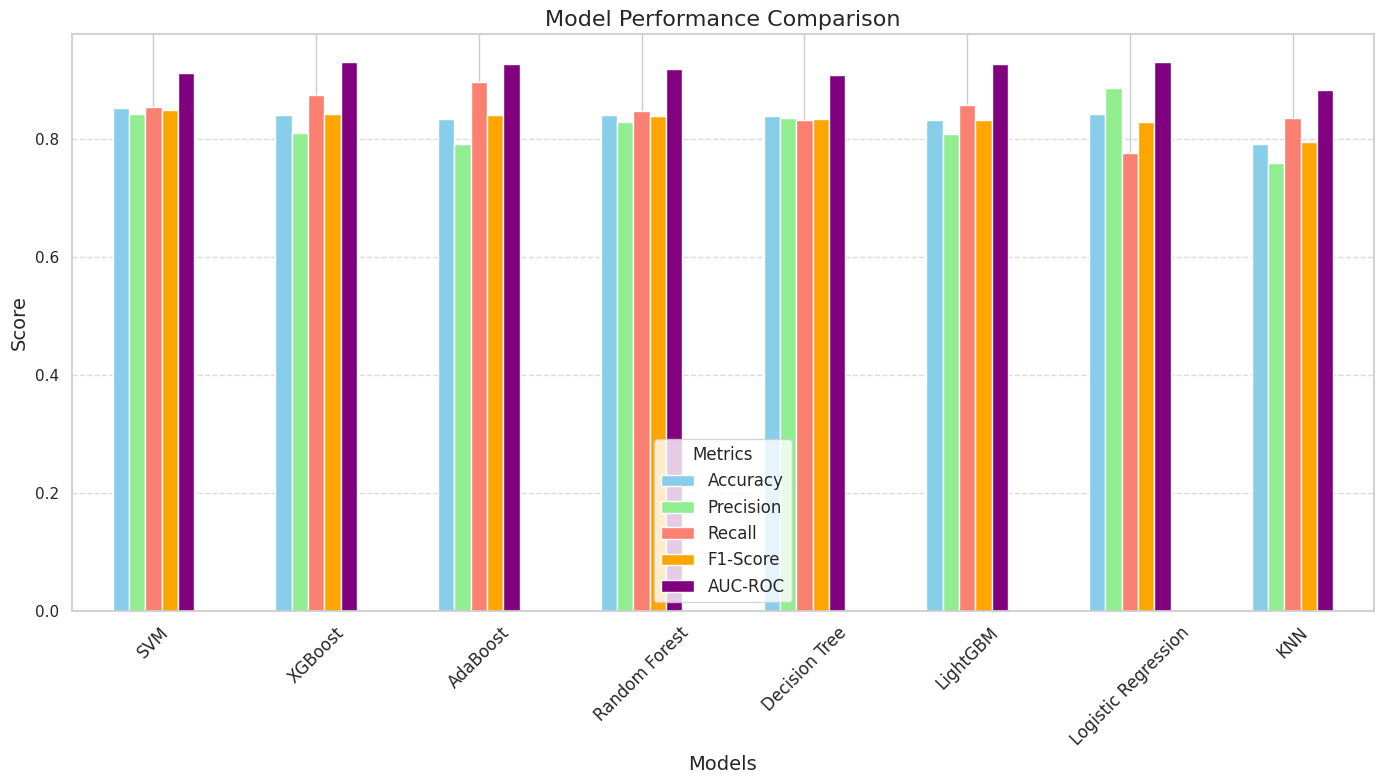

In [104]:
# Plot a bar chart for model comparison
def plot_model_comparison(results_df):
    # Sort by F1-Score for better visualization
    sorted_results = results_df.sort_values(by="F1-Score", ascending=False)

    # Plot the comparison
    plt.figure(figsize=(14, 8))
    sorted_results[["Accuracy", "Precision", "Recall", "F1-Score", "AUC-ROC"]].plot(
        kind="bar", figsize=(14, 8), color=["skyblue", "lightgreen", "salmon", "orange", "purple"]
    )
    plt.title("Model Performance Comparison", fontsize=16)
    plt.ylabel("Score", fontsize=14)
    plt.xlabel("Models", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title="Metrics", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_model_comparison(results_df)

Analysis
Model	F1-Score	AUC-ROC	Accuracy	Remarks
SVM	0.848073	0.910715	0.851276	Best F1-Score and Accuracy.
XGBoost	0.840834	0.930062	0.839068	Best AUC-ROC; solid F1-Score.
Random Forest	0.837472	0.917392	0.840178	Competitive across metrics.
AdaBoost	0.839400	0.926028	0.833518	High AUC and F1-Score.
Logistic Regression	0.827251	0.929650	0.842397	High AUC, but lower recall.
Decision Tree	0.832952	0.908437	0.837958	Balanced performance.
LightGBM	0.831486	0.925752	0.831299	High AUC, slightly lower F1.
KNN	0.794788	0.881806	0.790233	Lower across most metrics.
Final Recommendation
Use SVM as the primary model for its overall strong performance, especially in F1-Score.
Consider XGBoost as the second choice, especially if interpretability (via feature importance) or AUC is a priority.

In [105]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Define parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize GridSearchCV
grid_xgb = GridSearchCV(
    estimator=XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid=param_grid_xgb,
    cv=3,
    scoring='f1',
    verbose=0  # Reduce verbosity
)

# Fit GridSearchCV
print("Starting Grid Search...")
grid_xgb.fit(X_train, y_train)

# Print intermediate results
cv_results = pd.DataFrame(grid_xgb.cv_results_)
print("\nIntermediate Results:")
print(cv_results[['mean_test_score', 'params']])

# Get the best parameters and model
print("\nBest parameters for XGBoost:", grid_xgb.best_params_)
best_xgb = grid_xgb.best_estimator_


Starting Grid Search...

Intermediate Results:
     mean_test_score                                             params
0           0.836913  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
1           0.836913  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
2           0.835041  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
3           0.836913  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
4           0.839474  {'colsample_bytree': 0.8, 'learning_rate': 0.0...
..               ...                                                ...
103         0.835477  {'colsample_bytree': 1.0, 'learning_rate': 0.2...
104         0.831681  {'colsample_bytree': 1.0, 'learning_rate': 0.2...
105         0.834503  {'colsample_bytree': 1.0, 'learning_rate': 0.2...
106         0.831321  {'colsample_bytree': 1.0, 'learning_rate': 0.2...
107         0.832737  {'colsample_bytree': 1.0, 'learning_rate': 0.2...

[108 rows x 2 columns]

Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning

In [106]:
#Tuning SVM with GridSearchCV
# Define parameter grid for SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100],             # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'], # Kernel types
    'gamma': ['scale', 'auto']           # Kernel coefficient
}

# Initialize GridSearchCV for SVM
grid_svm = GridSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_grid=param_grid_svm,
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit GridSearchCV
print("Starting Grid Search for SVM...")
grid_svm.fit(X_train_scaled, y_train)  # Use scaled data for SVM

# Print intermediate results
cv_results_svm = pd.DataFrame(grid_svm.cv_results_)
print("\nIntermediate Results for SVM:")
print(cv_results_svm[['mean_test_score', 'params']])

# Get the best parameters and model
print("\nBest parameters for SVM:", grid_svm.best_params_)
best_svm = grid_svm.best_estimator_

Starting Grid Search for SVM...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Intermediate Results for SVM:
    mean_test_score                                            params
0          0.797206  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
1          0.813834     {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
2          0.830333    {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
3          0.797206   {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
4          0.814282      {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
5          0.831954     {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
6          0.802244    {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
7          0.829160       {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
8          0.839546      {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
9          0.802244     {'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
10         0.829160        {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
11         0.839546       {'C': 1, '

Step 5: Interpreting the Model with SHAP What we did:

Explained Random Forest Predictions:

Used SHAP to calculate how much the feature total_participations contributes to predictions. Visualized SHAP Values:

Computed the mean SHAP value across all samples and plotted it. Why this step matters:

SHAP helps explain why the model makes specific predictions, enhancing interpretability. How to interpret results:

Positive SHAP values for total_participations mean that higher participation increases the probability of winning gold. The magnitude of the SHAP value indicates the strength of the feature’s contribution.

Step 1: Evaluate the Tuned Models on the Test Set Summary In this step, we will evaluate the performance of the best-tuned models (XGBoost and Neural Network) on the test set using metrics like Confusion Matrix, Classification Report, AUC-ROC Curve, and Precision-Recall Curve.

1.1 Confusion Matrix What it does:

Displays the counts of True Positives, True Negatives, False Positives, and False Negatives. Helps to visualize the classification results. How to interpret:

High values along the diagonal indicate good performance. High off-diagonal values suggest misclassifications.

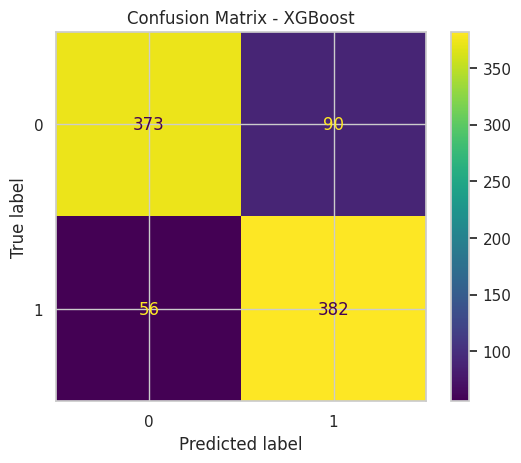

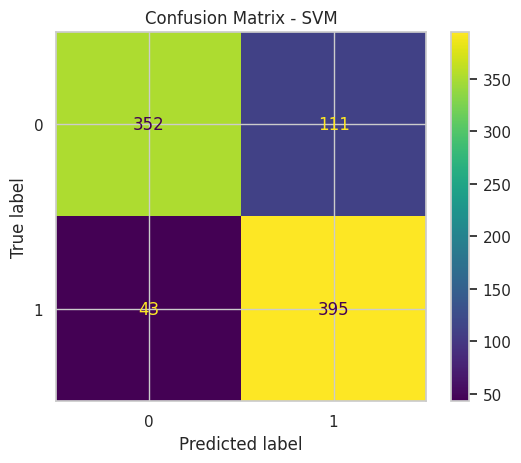

In [107]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plots a confusion matrix for the given true and predicted values.
    """
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# XGBoost Confusion Matrix
y_xgb_pred = best_xgb.predict(X_test)
plot_confusion_matrix(y_test, y_xgb_pred, "XGBoost")

# SVM Confusion Matrix
y_svm_pred = best_svm.predict(X_test_scaled)  # Scaled data for SVM
plot_confusion_matrix(y_test, y_svm_pred, "SVM")


1.2 Classification Report What it does:

Provides detailed metrics (Precision, Recall, F1-Score) for each class. How to interpret:

Precision: High precision means few false positives. Recall: High recall means few false negatives. F1-Score: Balances precision and recall.

In [108]:
# XGBoost Classification Report
print("XGBoost Classification Report:")
y_xgb_pred = best_xgb.predict(X_test)
print(classification_report(y_test, y_xgb_pred))

# SVM Classification Report
print("SVM Classification Report:")
y_svm_pred = best_svm.predict(X_test_scaled)  # Scaled data for SVM
print(classification_report(y_test, y_svm_pred))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       463
           1       0.81      0.87      0.84       438

    accuracy                           0.84       901
   macro avg       0.84      0.84      0.84       901
weighted avg       0.84      0.84      0.84       901

SVM Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82       463
           1       0.78      0.90      0.84       438

    accuracy                           0.83       901
   macro avg       0.84      0.83      0.83       901
weighted avg       0.84      0.83      0.83       901



1.3 AUC-ROC Curve What it does:

Plots the trade-off between True Positive Rate and False Positive Rate. How to interpret:

AUC closer to 1 indicates better performance. A curve closer to the top-left corner shows good separation of classes.

Step 2: Feature Importance Analysis Summary Feature importance tells us which features contributed the most to the model's predictions.

2.1 Horizontal Bar Plot for Feature Importance (XGBoost) What it does:

Displays feature importance as a horizontal bar plot. How to interpret:

Longer bars indicate higher importance.

2.2 SHAP Summary Plot What it does:

Explains the impact of each feature on individual predictions. How to interpret:

Positive SHAP values mean the feature pushes the prediction towards the positive class. Negative SHAP values mean the feature pushes the prediction towards the negative class.

<ipython-input-109-dafd805c62ac>:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




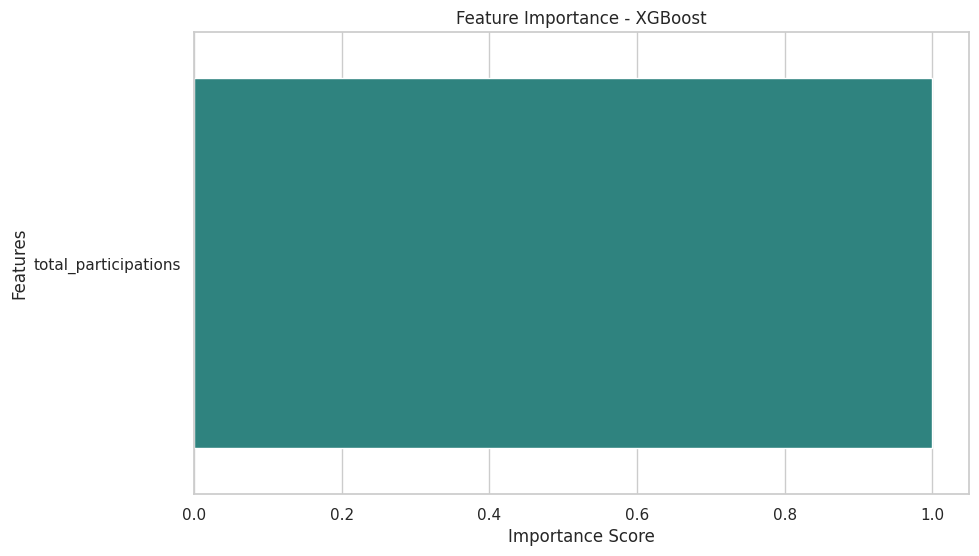

In [109]:
plt.figure(figsize=(10, 6))
sns.barplot(x=best_xgb.feature_importances_, y=X.columns, palette="viridis")
plt.title("Feature Importance - XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

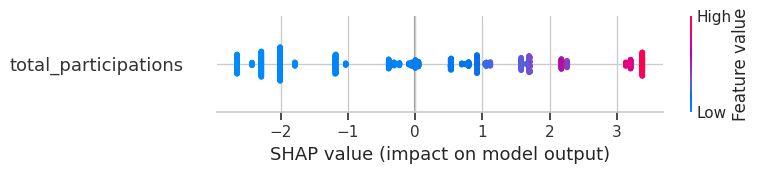

In [110]:
# XGBoost SHAP
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test)
shap.summary_plot(shap_values_xgb, X_test, feature_names=X.columns)

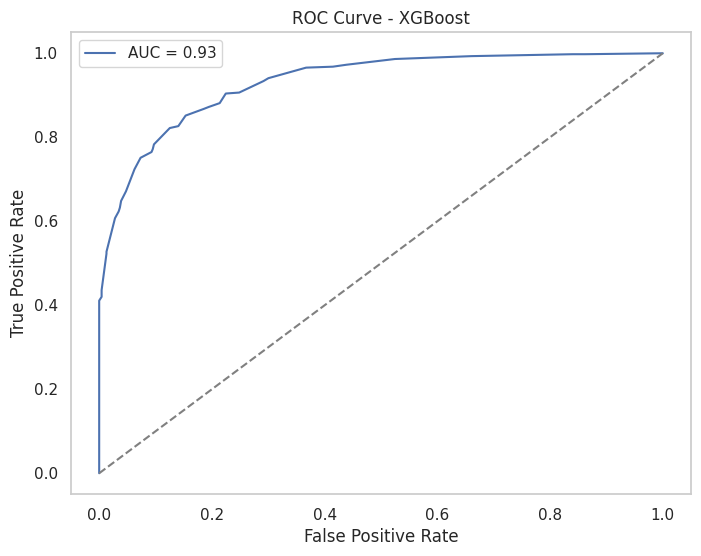

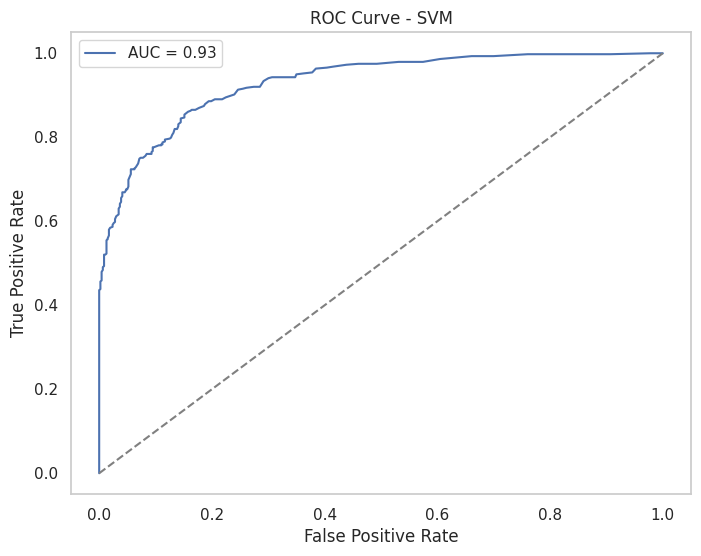

In [111]:
# Define the function to plot ROC Curve for any model
def plot_roc_curve(y_true, y_proba, model_name):
    """
    Plots the ROC curve and calculates the AUC for a given model.
    """
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

# XGBoost AUC-ROC Curve
y_xgb_proba = best_xgb.predict_proba(X_test)[:, 1]
plot_roc_curve(y_test, y_xgb_proba, "XGBoost")

# SVM AUC-ROC Curve
y_svm_proba = best_svm.predict_proba(X_test_scaled)[:, 1]
plot_roc_curve(y_test, y_svm_proba, "SVM")

Step 3: Precision-Recall Curve Summary Precision-Recall curves show the trade-off between precision and recall across different thresholds.

How to interpret:

A curve closer to the top-right corner indicates better performance. Helps to decide the threshold based on business needs.

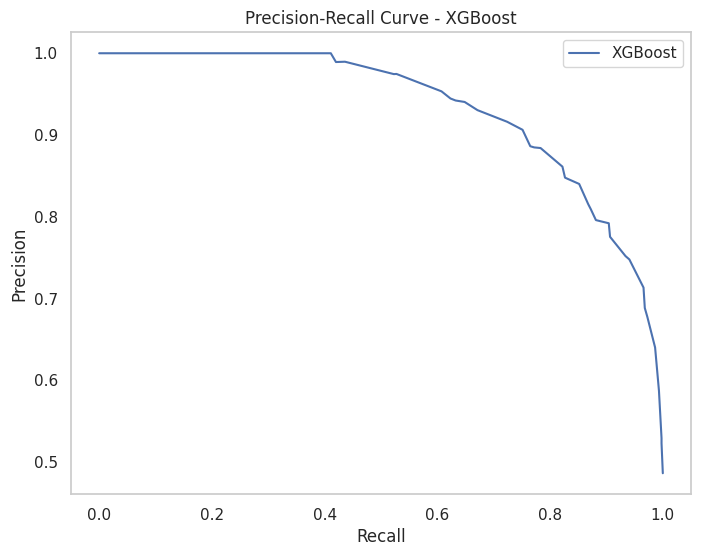

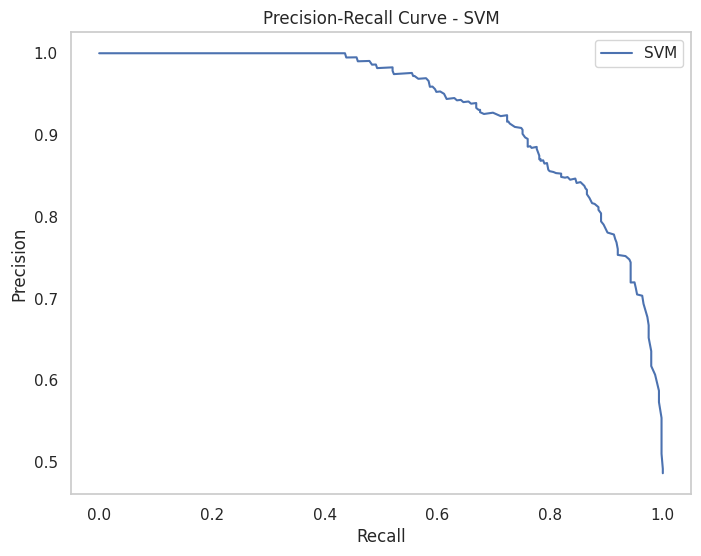

In [112]:
# Define the function to plot Precision-Recall Curve for any model
def plot_precision_recall_curve(y_true, y_proba, model_name):
    """
    Plots the Precision-Recall curve for a given model.
    """
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"{model_name}")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid()
    plt.legend()
    plt.show()

# XGBoost Precision-Recall Curve
y_xgb_proba = best_xgb.predict_proba(X_test)[:, 1]  # Ensure best_xgb is available
plot_precision_recall_curve(y_test, y_xgb_proba, "XGBoost")

# SVM Precision-Recall Curve
y_svm_proba = best_svm.predict_proba(X_test_scaled)[:, 1]  # Ensure best_svm is available
plot_precision_recall_curve(y_test, y_svm_proba, "SVM")


Summary of Results EDA Findings:

Countries that participate in more events are more likely to win gold. The dataset was imbalanced, with more countries not winning gold than those that did. Model Evaluation:

Both Random Forest and Neural Network performed well, but the specific performance metrics (e.g., F1-score and AUC-ROC) revealed which was better. SHAP Interpretation:

The feature total_participations was the key driver of the model’s predictions. Higher participation had a strong positive impact on the likelihood of winning gold.

# **Regression Model**

In [113]:
# Step 1: Load the Data
# ---------------------------------------------------------------
df = pd.read_csv(dataset_url)

# Step 2: Initial Data Exploration
# ---------------------------------------------------------------
print("Data Shape:", df.shape)
print(df.head())
df.info()

# Step 3: Data Cleaning
# ---------------------------------------------------------------
df['Medal'] = df['Medal'].fillna('No Medal')


Data Shape: (252565, 11)
   player_id                   Name Sex            Team  NOC  Year  Season  \
0          0              A Dijiang   M           China  CHN  1992  Summer   
1          1               A Lamusi   M           China  CHN  2012  Summer   
2          2            Gunnar Aaby   M         Denmark  DEN  1920  Summer   
3          3            Edgar Aabye   M  Denmark/Sweden  DEN  1900  Summer   
4         26  Cornelia (-strannood)   F     Netherlands  NED  1932  Summer   

          City       Sport                         Event     Medal  
0    Barcelona  Basketball   Basketball Men's Basketball  No medal  
1       London        Judo  Judo Men's Extra-Lightweight  No medal  
2    Antwerpen    Football       Football Men's Football  No medal  
3        Paris  Tug-Of-War   Tug-Of-War Men's Tug-Of-War      Gold  
4  Los Angeles   Athletics  Athletics Women's 100 metres  No medal  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252565 entries, 0 to 252564
Data columns (

In [114]:
# Step 3: Feature Engineering for Medal Counts
# ---------------------------------------------------------------
df['Medal_Count'] = df['Medal'].apply(lambda x: 0 if x == 'No Medal' else 1)

# Aggregate total medals by (NOC, Year)
country_year = df.groupby(['NOC', 'Year'], as_index=False)['Medal_Count'].sum()
country_year.rename(columns={'Medal_Count': 'Total_Medals'}, inplace=True)

# Number of athletes
athletes_per_country_year = df.groupby(['NOC', 'Year'])['Name'].nunique().reset_index()
athletes_per_country_year.rename(columns={'Name': 'Num_Athletes'}, inplace=True)

# Number of sports
sports_per_country_year = df.groupby(['NOC', 'Year'])['Sport'].nunique().reset_index()
sports_per_country_year.rename(columns={'Sport': 'Num_Sports'}, inplace=True)

# Merge features
country_year = country_year.merge(athletes_per_country_year, on=['NOC', 'Year'], how='left')
country_year = country_year.merge(sports_per_country_year, on=['NOC', 'Year'], how='left')

# Season flag
season_per_country_year = df.groupby(['NOC','Year'])['Season'].first().reset_index()
country_year = country_year.merge(season_per_country_year, on=['NOC','Year'], how='left')
country_year['Season_Flag'] = country_year['Season'].apply(lambda x: 1 if x == 'Summer' else 0)
country_year.drop(columns='Season', inplace=True)

# Reset index after merges
country_year.reset_index(drop=True, inplace=True)

# Step 5: Historical Performance Feature
# ---------------------------------------------------------------
country_year = country_year.sort_values(by=['NOC','Year']).reset_index(drop=True)
country_year['Avg_Past_Medals'] = (country_year.groupby('NOC')['Total_Medals']
                                   .apply(lambda x: x.shift().expanding().mean())
                                   .reset_index(level=0, drop=True))
country_year['Avg_Past_Medals'] = country_year['Avg_Past_Medals'].fillna(0)

print("Data after adding historical feature:")
print(country_year.head(10))

Data after adding historical feature:
   NOC  Year  Total_Medals  Num_Athletes  Num_Sports  Season_Flag  \
0  AFG  1936            16            15           2            1   
1  AFG  1948            25            22           2            1   
2  AFG  1956            12            12           1            1   
3  AFG  1960            16            12           2            1   
4  AFG  1964             8             8           1            1   
5  AFG  1968             5             5           1            1   
6  AFG  1972             8             8           1            1   
7  AFG  1980            11            11           2            1   
8  AFG  1988             5             5           1            1   
9  AFG  1996             2             2           1            1   

   Avg_Past_Medals  
0         0.000000  
1        16.000000  
2        20.500000  
3        17.666667  
4        17.250000  
5        15.400000  
6        13.666667  
7        12.857143  
8        12.6


Base Model Results:
                          MSE       MAE        R²
Linear Regression  275.745515  8.928938  0.982263
Random Forest      232.524404  7.837499  0.985044
Gradient Boosting  203.867028  7.494575  0.986887
XGBoost            282.690209  8.560976  0.981817

Tuning Random Forest...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Random Forest Params: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 300}

Tuning Gradient Boosting...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Gradient Boosting Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Tuned Random Forest - MSE: 227.0597, MAE: 7.7124, R²: 0.9854
Tuned Gradient Boosting - MSE: 203.8670, MAE: 7.4946, R²: 0.9869


<Figure size 1000x600 with 0 Axes>

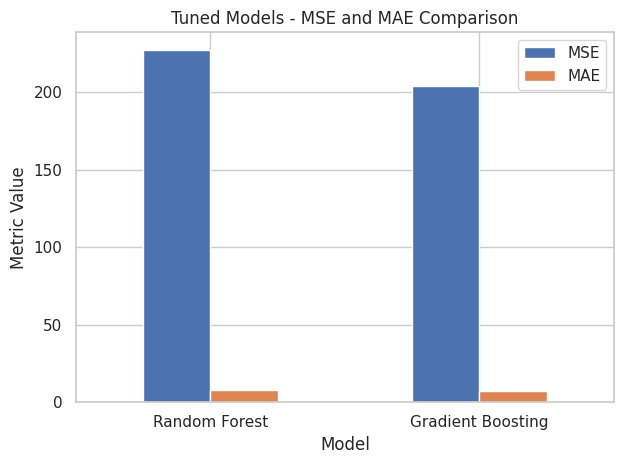

<Figure size 1000x600 with 0 Axes>

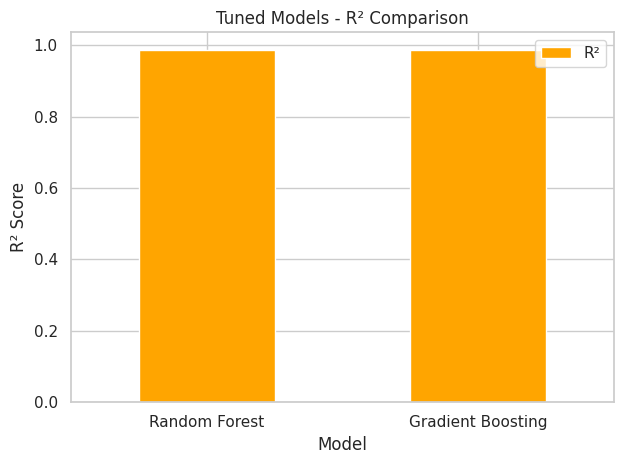


Best model selected after tuning: Gradient Boosting with R² = 0.9869


In [115]:
# Step 6: Prepare Data for Modeling
# ---------------------------------------------------------------
features = ['Num_Athletes', 'Num_Sports', 'Season_Flag', 'Avg_Past_Medals']
X = country_year[features]
y = country_year['Total_Medals']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Base Model Training and Evaluation
# ---------------------------------------------------------------
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, objective='reg:squarederror')
}

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, mae, r2

base_results = {}
for name, m in models.items():
    m.fit(X_train, y_train)
    mse, mae, r2 = evaluate_model(m, X_test, y_test)
    base_results[name] = {'MSE': mse, 'MAE': mae, 'R²': r2}

base_results_df = pd.DataFrame(base_results).T
print("\nBase Model Results:")
print(base_results_df)

# Step 8: Hyperparameter Tuning for Top Two Models (e.g. Random Forest and Gradient Boosting)
# ---------------------------------------------------------------
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}

gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7]
}

print("\nTuning Random Forest...")
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42),
                       rf_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
rf_grid.fit(X_train, y_train)
print("Best Random Forest Params:", rf_grid.best_params_)

print("\nTuning Gradient Boosting...")
gb_grid = GridSearchCV(GradientBoostingRegressor(random_state=42),
                       gb_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
gb_grid.fit(X_train, y_train)
print("Best Gradient Boosting Params:", gb_grid.best_params_)

best_rf = rf_grid.best_estimator_
best_gb = gb_grid.best_estimator_

rf_mse, rf_mae, rf_r2 = evaluate_model(best_rf, X_test, y_test)
gb_mse, gb_mae, gb_r2 = evaluate_model(best_gb, X_test, y_test)

print("\nTuned Random Forest - MSE: {:.4f}, MAE: {:.4f}, R²: {:.4f}".format(rf_mse, rf_mae, rf_r2))
print("Tuned Gradient Boosting - MSE: {:.4f}, MAE: {:.4f}, R²: {:.4f}".format(gb_mse, gb_mae, gb_r2))

# Compare tuned models visually (Separate MSE/MAE and R² plots)
tuned_results = pd.DataFrame({
    'MSE': [rf_mse, gb_mse],
    'MAE': [rf_mae, gb_mae],
    'R²': [rf_r2, gb_r2]
}, index=['Random Forest', 'Gradient Boosting'])

# Plot MSE and MAE in one graph
plt.figure(figsize=(10,6))
tuned_results[['MSE','MAE']].plot(kind='bar', rot=0)
plt.title("Tuned Models - MSE and MAE Comparison")
plt.xlabel("Model")
plt.ylabel("Metric Value")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Plot R² in another graph
plt.figure(figsize=(10,6))
tuned_results[['R²']].plot(kind='bar', rot=0, color='orange')
plt.title("Tuned Models - R² Comparison")
plt.xlabel("Model")
plt.ylabel("R² Score")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Step 9: Select Best Model
# ---------------------------------------------------------------
if gb_r2 >= rf_r2:
    final_model = best_gb
    best_model_name = "Gradient Boosting"
else:
    final_model = best_rf
    best_model_name = "Random Forest"

print(f"\nBest model selected after tuning: {best_model_name} with R² = {max(gb_r2, rf_r2):.4f}")

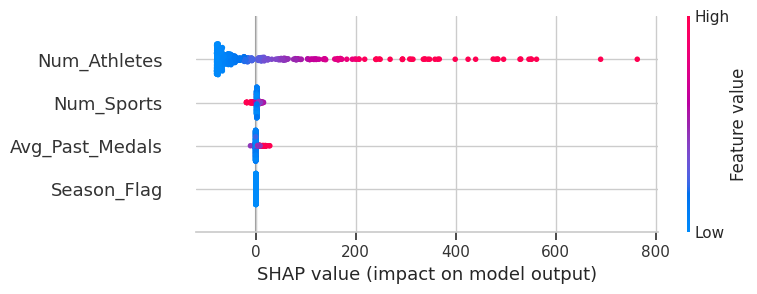

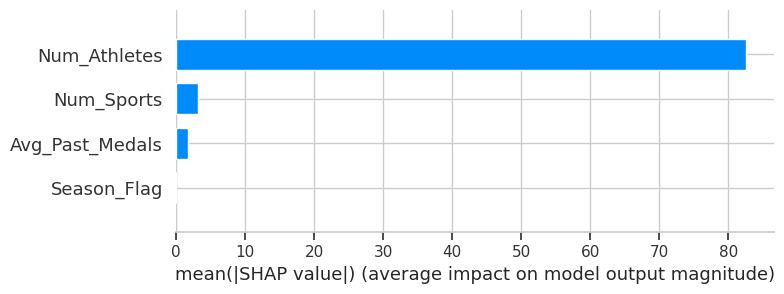

In [116]:
# Step 10: SHAP Analysis
# ---------------------------------------------------------------
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=features)
shap.summary_plot(shap_values, X_test, plot_type='bar', feature_names=features)

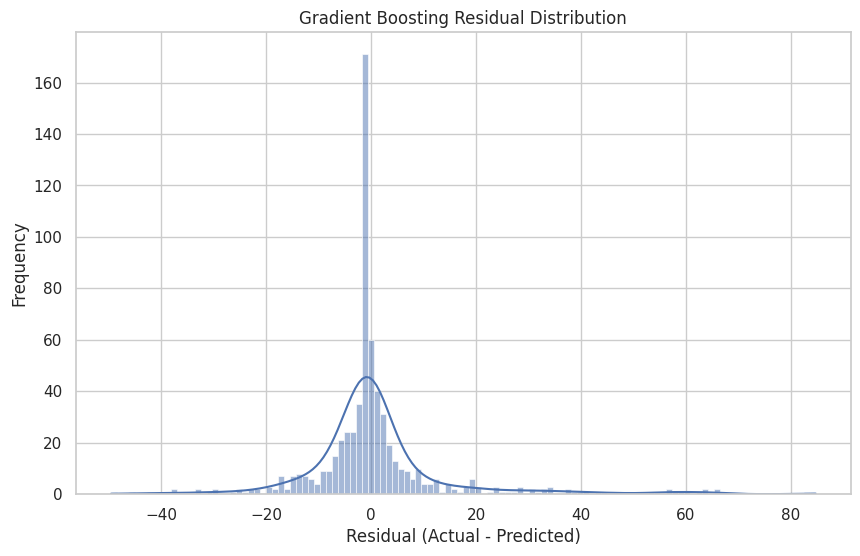

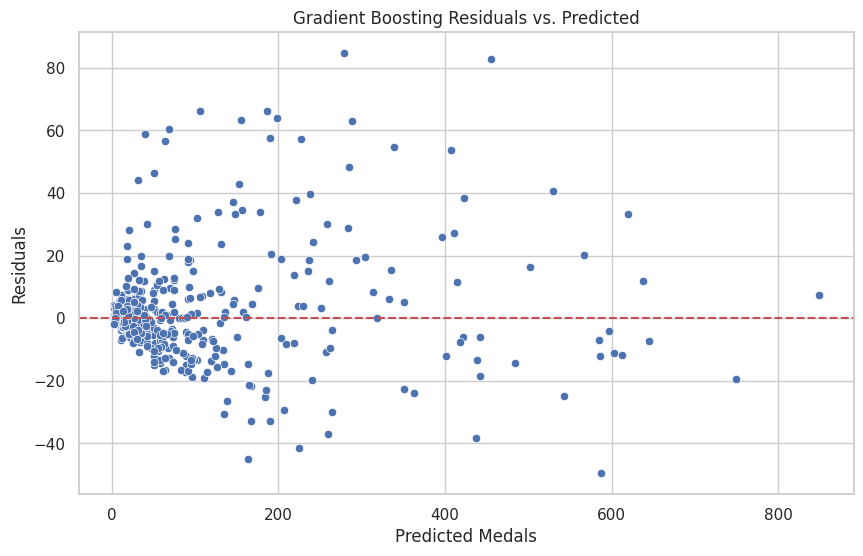

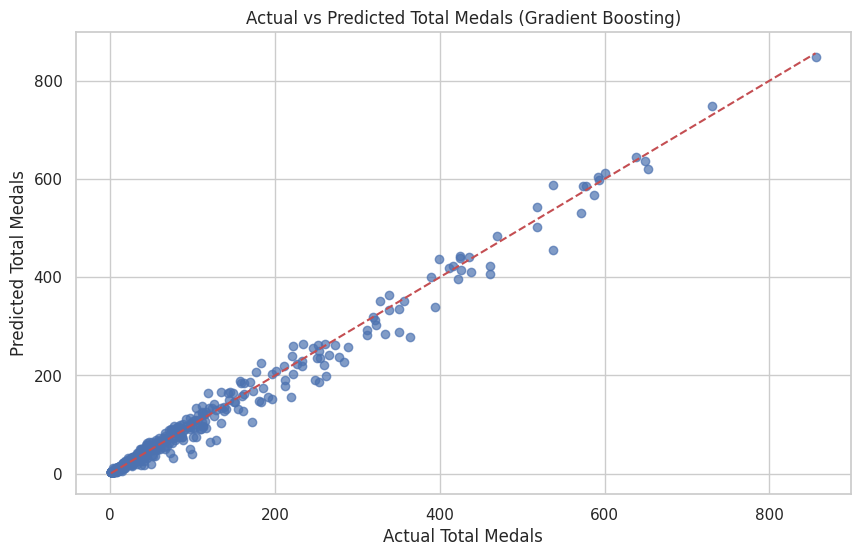


Final Model Performance:
Gradient Boosting - MSE: 203.8670, MAE: 7.4946, R²: 0.9869


In [117]:
# Step 11: Residual Analysis on Best Model
# ---------------------------------------------------------------
y_pred = final_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True)
plt.title(f"{best_model_name} Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title(f"{best_model_name} Residuals vs. Predicted")
plt.xlabel("Predicted Medals")
plt.ylabel("Residuals")
plt.show()

# Actual vs Predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()],[y_test.min(), y_test.max()], 'r--')
plt.title(f"Actual vs Predicted Total Medals ({best_model_name})")
plt.xlabel("Actual Total Medals")
plt.ylabel("Predicted Total Medals")
plt.grid(True)
plt.show()

# Step 12: Conclusion
# ---------------------------------------------------------------
final_mse, final_mae, final_r2 = evaluate_model(final_model, X_test, y_test)
print("\nFinal Model Performance:")
print(f"{best_model_name} - MSE: {final_mse:.4f}, MAE: {final_mae:.4f}, R²: {final_r2:.4f}")

# **Neural Network**

In [118]:
# ======================================
# STEP 1: Data Loading
np.random.seed(42)
df = pd.read_csv(dataset_url)
df.head()

,player_id,Name,Sex,Team,NOC,Year,Season,City,Sport,Event,Medal
0,0,A Dijiang,M,China,CHN,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,No medal
1,1,A Lamusi,M,China,CHN,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,No medal
2,2,Gunnar Aaby,M,Denmark,DEN,1920,Summer,Antwerpen,Football,Football Men's Football,No medal
3,3,Edgar Aabye,M,Denmark/Sweden,DEN,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,26,Cornelia (-strannood),F,Netherlands,NED,1932,Summer,Los Angeles,Athletics,Athletics Women's 100 metres,No medal


In [119]:
agg_df = df.groupby(['NOC','Year']).agg(
    gold_count=('Medal', lambda x: (x=='Gold').sum()),
    silver_count=('Medal', lambda x: (x=='Silver').sum()),
    bronze_count=('Medal', lambda x: (x=='Bronze').sum()),
    total_athletes=('Name','count'),
    total_events=('Event','nunique'),
    season_mode=('Season', lambda x: x.mode()[0] if not x.mode().empty else 'Summer')
).reset_index()

# Example host feature:
host_map = {
    1900: "FRA",
    1920: "BEL",
    1992: "ESP",
    2012: "GBR",
    1932: "USA",
    1952: "FIN",
    2000: "AUS",
    1996: "USA",
    1912: "SWE"
}
agg_df['host'] = agg_df.apply(lambda row: 1 if row['NOC'] == host_map.get(row['Year'], '') else 0, axis=1)

agg_df.head()

,NOC,Year,gold_count,silver_count,bronze_count,total_athletes,total_events,season_mode,host
0,AFG,1936,0,0,0,16,4,Summer,0
1,AFG,1948,0,0,0,25,2,Summer,0
2,AFG,1956,0,0,0,12,1,Summer,0
3,AFG,1960,0,0,0,16,13,Summer,0
4,AFG,1964,0,0,0,8,8,Summer,0


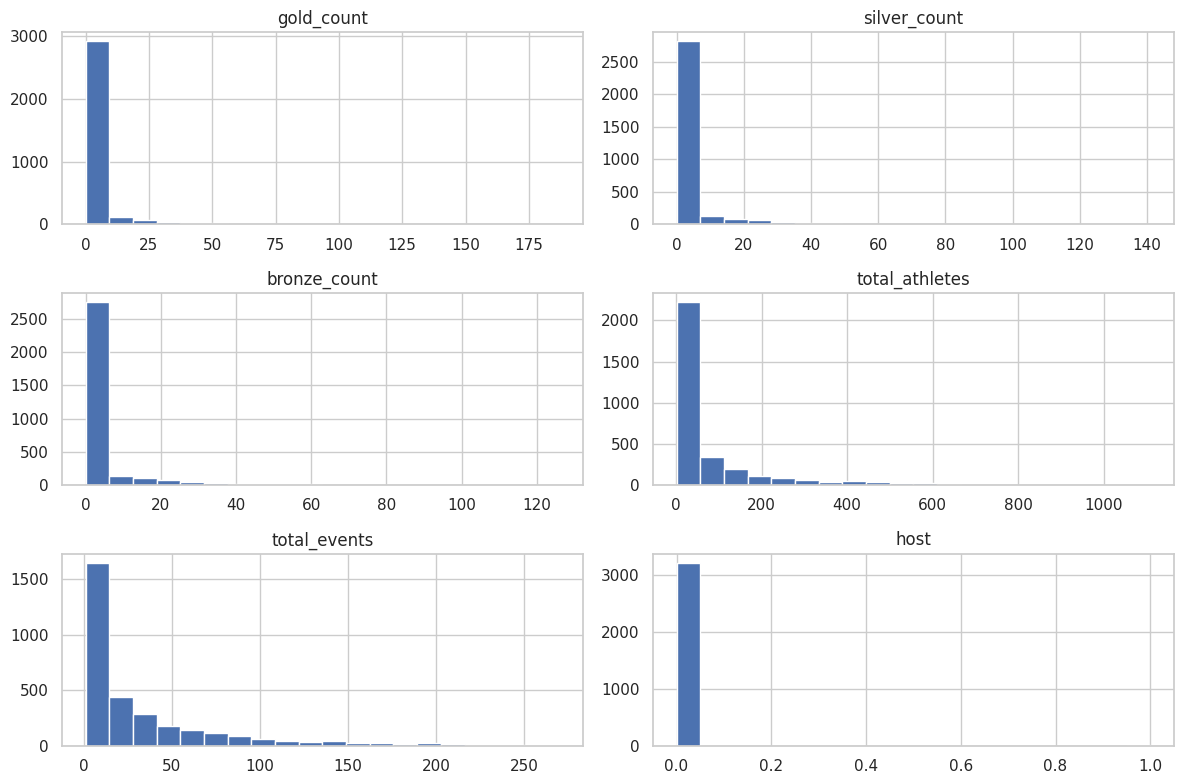

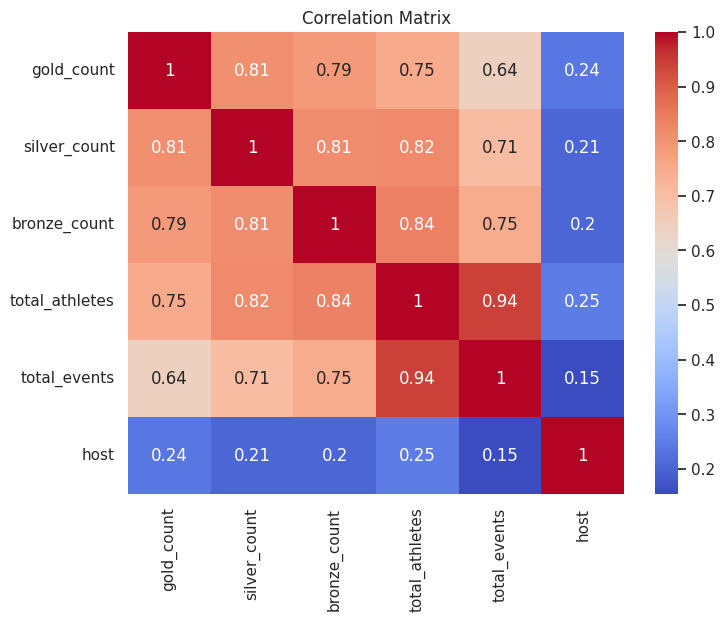

In [120]:
# ======================================
# STEP 3: Exploratory Data Analysis (EDA)
#
# Check distributions, correlations
# ======================================

numeric_features = ['gold_count','silver_count','bronze_count','total_athletes','total_events','host']
agg_df[numeric_features].hist(figsize=(12,8), bins=20)
plt.tight_layout()
plt.show()

# Correlation matrix
corr = agg_df[numeric_features].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


In [121]:
# ======================================
# STEP 4: Prepare Data for Modeling
#
# Targets: gold_count, silver_count, bronze_count (multi-output regression)
# Features: NOC (cat), Year (num), season_mode (cat), total_athletes (num), total_events (num), host (num)
# ======================================

X = agg_df[['NOC','Year','season_mode','total_athletes','total_events','host']]
y = agg_df[['gold_count','silver_count','bronze_count']]

cat_cols = ['NOC','season_mode']
num_cols = ['Year','total_athletes','total_events','host']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ('num', StandardScaler(), num_cols)
])

X_transformed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)
print("Shape of Training Set:", X_train.shape)
print("Shape of Testing Set:", X_test.shape)
print("Shape of Training Targets:", y_train.shape)
print("Shape of Testing Targets:", y_test.shape)

Shape of Training Set: (2577, 239)
Shape of Testing Set: (645, 239)
Shape of Training Targets: (2577, 3)
Shape of Testing Targets: (645, 3)


In [122]:
# ======================================
# STEP 5: Build Two Different Neural Network Models
#
# Model A: ReLU activation in hidden layers
# Model B: tanh activation in hidden layers
#
# We'll try different batch sizes and epochs to find the best model.
# Compare performance using R² and MAE.
# ======================================

def create_model(input_dim, hidden_layers=[64,32], activation='relu', learning_rate=0.001):
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(input_dim,)))
    for units in hidden_layers:
        model.add(layers.Dense(units, activation=activation))
    # Output layer: 3 outputs for gold, silver, bronze
    model.add(layers.Dense(3, activation='linear'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse')  # MSE for regression
    return model

# Assuming X_train, y_train, X_test, y_test are already defined
# Ensure y_train and y_test are in the form of dictionaries or DataFrames
# For example:
# y_train = pd.DataFrame({'gold_count': ..., 'silver_count': ..., 'bronze_count': ...})
# y_test = pd.DataFrame({'gold_count': ..., 'silver_count': ..., 'bronze_count': ...})

input_dim = X_train.shape[1]

batch_sizes = [32, 64]
epochs_list = [20, 40]

# Initialize variables to track the best models
best_score = -np.inf  # for R², higher is better
best_config = None
best_model = None
best_model_type = None

# DataFrames to store performance metrics
performance_records = []

# We'll evaluate the model by the average R² of the three outputs.
def evaluate_model(y_true, y_pred):
    r2_gold = r2_score(y_true['gold_count'], y_pred[:,0])
    r2_silver = r2_score(y_true['silver_count'], y_pred[:,1])
    r2_bronze = r2_score(y_true['bronze_count'], y_pred[:,2])
    avg_r2 = (r2_gold + r2_silver + r2_bronze) / 3.0

    mae_gold = mean_absolute_error(y_true['gold_count'], y_pred[:,0])
    mae_silver = mean_absolute_error(y_true['silver_count'], y_pred[:,1])
    mae_bronze = mean_absolute_error(y_true['bronze_count'], y_pred[:,2])
    avg_mae = (mae_gold + mae_silver + mae_bronze) / 3.0

    return avg_r2, avg_mae

# To store the best Model A and Model B separately
best_model_a = None
best_score_a = -np.inf
best_config_a = None

best_model_b = None
best_score_b = -np.inf
best_config_b = None

for batch_size in batch_sizes:
    for epochs in epochs_list:
        # Model A (ReLU)
        model_a = create_model(input_dim, activation='relu')
        history_a = model_a.fit(X_train, y_train, validation_split=0.2,
                                epochs=epochs, batch_size=batch_size, verbose=0)
        y_pred_a = model_a.predict(X_test)
        score_a, mae_a = evaluate_model(y_test, y_pred_a)

        performance_records.append({
            'Model': 'A (ReLU)',
            'Batch Size': batch_size,
            'Epochs': epochs,
            'Avg R²': score_a,
            'Avg MAE': mae_a
        })

        if score_a > best_score_a:
            best_score_a = score_a
            best_config_a = (batch_size, epochs)
            best_model_a = model_a
            history_best_a = history_a

        # Model B (tanh)
        model_b = create_model(input_dim, activation='tanh')
        history_b = model_b.fit(X_train, y_train, validation_split=0.2,
                                epochs=epochs, batch_size=batch_size, verbose=0)
        y_pred_b = model_b.predict(X_test)
        score_b, mae_b = evaluate_model(y_test, y_pred_b)

        performance_records.append({
            'Model': 'B (tanh)',
            'Batch Size': batch_size,
            'Epochs': epochs,
            'Avg R²': score_b,
            'Avg MAE': mae_b
        })

        if score_b > best_score_b:
            best_score_b = score_b
            best_config_b = (batch_size, epochs)
            best_model_b = model_b
            history_best_b = history_b

# Convert performance records to DataFrame
performance_df = pd.DataFrame(performance_records)

print("Best Model A (ReLU) configuration:", best_config_a, "with avg R² score:", best_score_a)
print("Best Model B (tanh) configuration:", best_config_b, "with avg R² score:", best_score_b)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Best Model A (ReLU) configuration: (32, 40) with avg R² score: 0.7951438625653585
Best Model B (tanh) configuration: (32, 40) with avg R² score: 0.7225924730300903


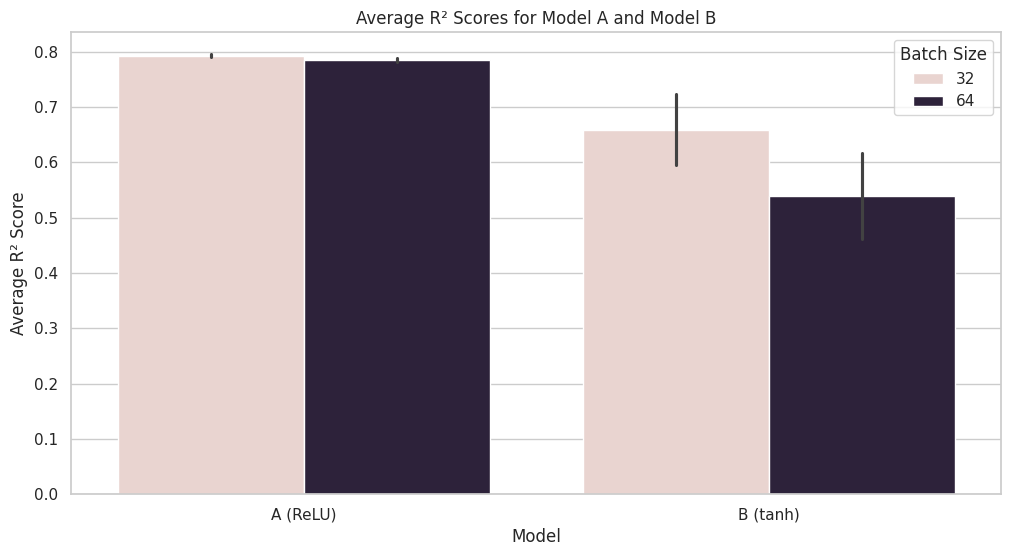

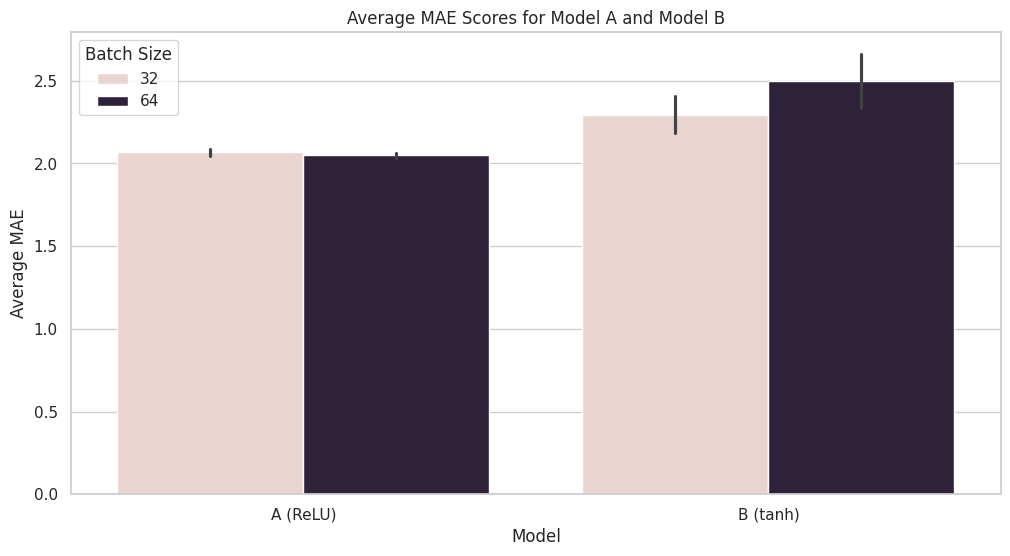

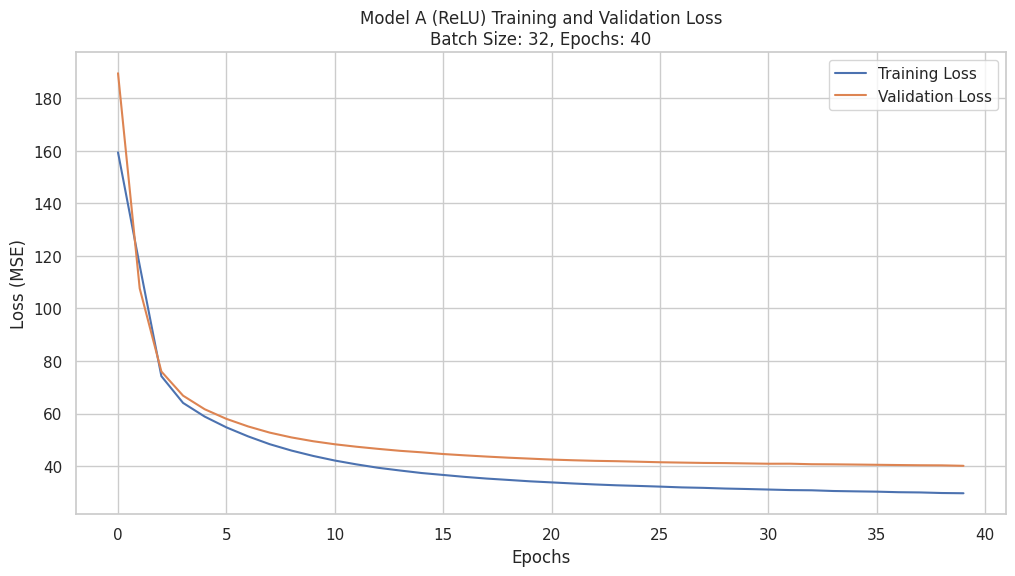

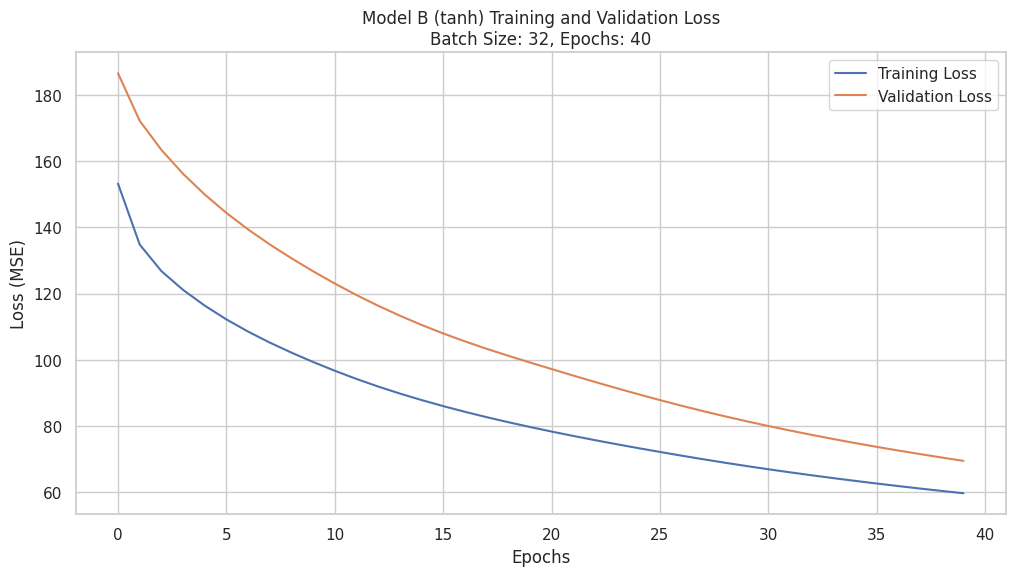

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


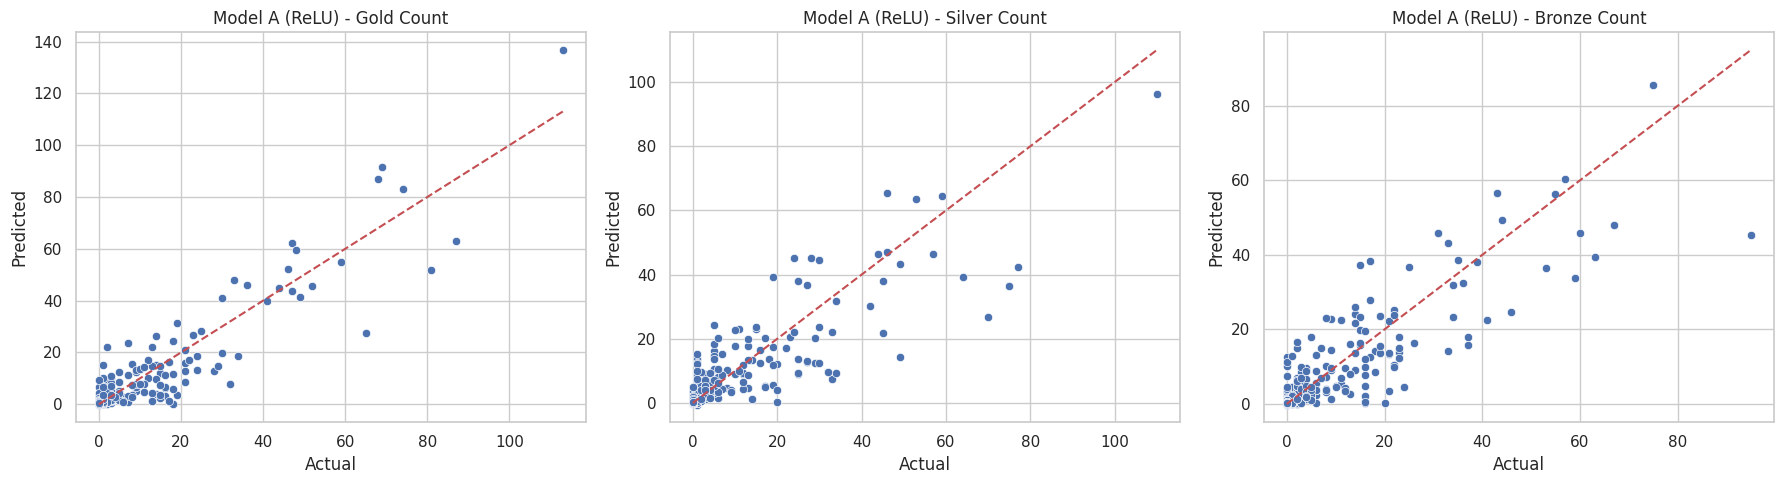

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


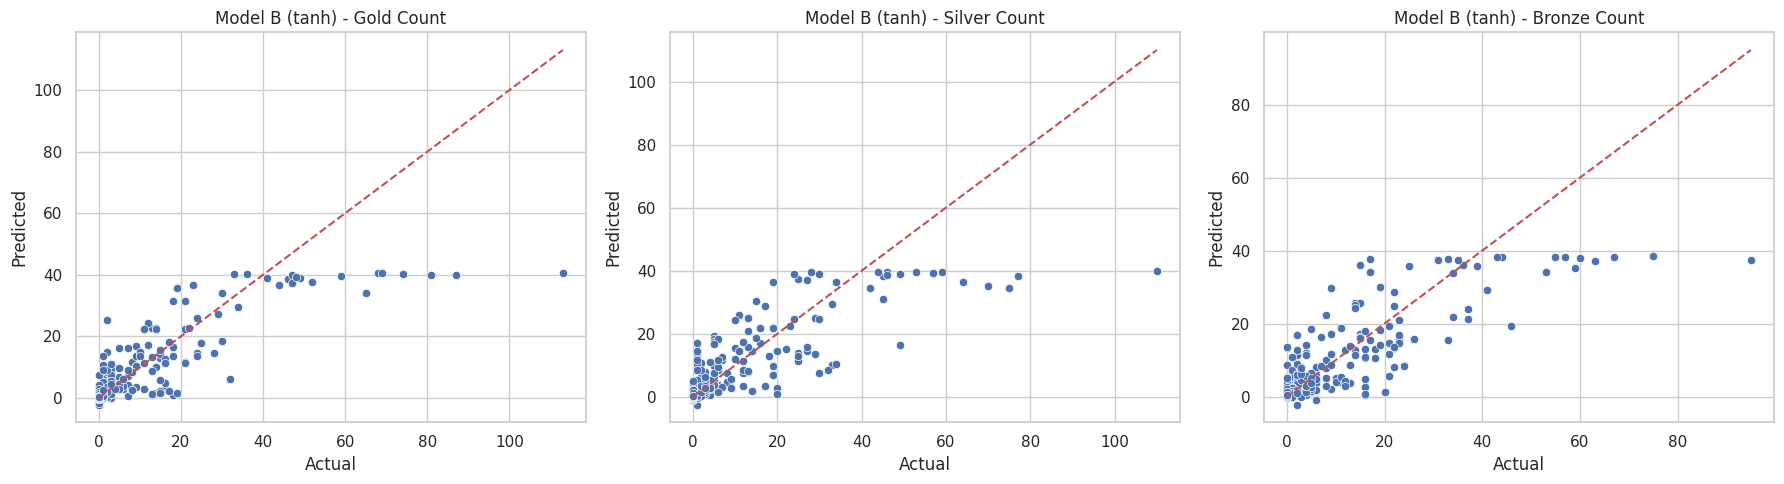

In [123]:
# ======================================
# Plotting Performance Metrics
# ======================================

# Set plot style
sns.set(style="whitegrid")

# 1. Plot Average R² Scores
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Avg R²', hue='Batch Size', data=performance_df)
plt.title('Average R² Scores for Model A and Model B')
plt.ylabel('Average R² Score')
plt.xlabel('Model')
plt.legend(title='Batch Size')
plt.show()

# 2. Plot Average MAE Scores
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='Avg MAE', hue='Batch Size', data=performance_df)
plt.title('Average MAE Scores for Model A and Model B')
plt.ylabel('Average MAE')
plt.xlabel('Model')
plt.legend(title='Batch Size')
plt.show()

# 3. Plot Training and Validation Loss for Best Model A
plt.figure(figsize=(12, 6))
plt.plot(history_best_a.history['loss'], label='Training Loss')
plt.plot(history_best_a.history['val_loss'], label='Validation Loss')
plt.title(f'Model A (ReLU) Training and Validation Loss\nBatch Size: {best_config_a[0]}, Epochs: {best_config_a[1]}')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# 4. Plot Training and Validation Loss for Best Model B
plt.figure(figsize=(12, 6))
plt.plot(history_best_b.history['loss'], label='Training Loss')
plt.plot(history_best_b.history['val_loss'], label='Validation Loss')
plt.title(f'Model B (tanh) Training and Validation Loss\nBatch Size: {best_config_b[0]}, Epochs: {best_config_b[1]}')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# 5. Plot Predicted vs Actual for Best Model A
y_pred_best_a = best_model_a.predict(X_test)

plt.figure(figsize=(18, 5))

for i, medal in enumerate(['Gold', 'Silver', 'Bronze']):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=y_test[f'{medal.lower()}_count'], y=y_pred_best_a[:,i])
    plt.plot([y_test[f'{medal.lower()}_count'].min(), y_test[f'{medal.lower()}_count'].max()],
             [y_test[f'{medal.lower()}_count'].min(), y_test[f'{medal.lower()}_count'].max()],
             'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Model A (ReLU) - {medal} Count')

plt.tight_layout()
plt.show()

# 6. Plot Predicted vs Actual for Best Model B
y_pred_best_b = best_model_b.predict(X_test)

plt.figure(figsize=(18, 5))

for i, medal in enumerate(['Gold', 'Silver', 'Bronze']):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(x=y_test[f'{medal.lower()}_count'], y=y_pred_best_b[:,i])
    plt.plot([y_test[f'{medal.lower()}_count'].min(), y_test[f'{medal.lower()}_count'].max()],
             [y_test[f'{medal.lower()}_count'].min(), y_test[f'{medal.lower()}_count'].max()],
             'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Model B (tanh) - {medal} Count')

plt.tight_layout()
plt.show()